In [1]:
import pandas as pd
import networkx as nx
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from sklearn.metrics import confusion_matrix, classification_report
import os
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

data_path = 'stage3_data_cleaning/v2/type1_label_merged_final_decoded_clean3.xlsx'
data = pd.read_excel(data_path)
data['can_id'] = data['can_id'].astype(str)

output_dir = "can_graphs/v9"
visualization_dir = os.path.join(output_dir, "visualizations")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)

In [2]:
import torch
from torch.nn import LSTM

class LSTMAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LSTMAggregator, self).__init__()
        self.lstm = LSTM(in_channels, out_channels, batch_first=True)

    def forward(self, x, edge_index):
        # Assuming x is of shape [num_nodes, num_features]
        # Reshape x to [num_nodes, 1, num_features] for LSTM
        x = x.unsqueeze(1)
        x, (hn, cn) = self.lstm(x)
        # Flatten the output to [num_nodes, out_channels]
        x = x.squeeze(1)
        return x

In [3]:
from torch_geometric.nn import conv.SAGEConv
import torch.nn.functional as F

class EGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EGraphSAGE, self).__init__()
        self.lstm_agg = LSTMAggregator(in_channels, hidden_channels)
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr=self.lstm_agg)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr=self.lstm_agg)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)


In [4]:
def calculate_optimized_pagerank(G, damping_factor=0.7):
    N = len(G)
    pagerank = {node: 1 / N for node in G}
    for _ in range(100):  # Iterate 100 times for convergence
        new_pagerank = {}
        for node in G:
            rank_sum = 0
            for neighbor in G.predecessors(node):
                weight_sum = sum([G[neighbor][succ]['weight'] for succ in G.successors(neighbor)])
                rank_sum += pagerank[neighbor] * (G[neighbor][node]['weight'] / weight_sum)
            new_pagerank[node] = (1 - damping_factor) / N + damping_factor * rank_sum
        pagerank = new_pagerank
    nx.set_node_attributes(G, pagerank, 'pagerank')
    return G

In [5]:
def create_graph(window_df):
    G = nx.DiGraph()
    index_tracker = {}
    
    for i in range(len(window_df) - 1):
        node1 = window_df.iloc[i]['can_id']
        node2 = window_df.iloc[i + 1]['can_id']
        timestamp_diff = window_df.iloc[i + 1]['timestamp'] - window_df.iloc[i]['timestamp']
        label = window_df.iloc[i]['label']
        transfer_id1 = window_df.iloc[i]['transfer_ID']
        transfer_id2 = window_df.iloc[i + 1]['transfer_ID']
        
        if node1 != node2 or transfer_id1 != transfer_id2:  # Avoid self-loops
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += timestamp_diff
            else:
                G.add_edge(node1, node2, weight=timestamp_diff)
        
        if node1 not in index_tracker:
            index_tracker[node1] = []
        index_tracker[node1].append((i, label))
        
        # if i == len(window_df)-1:
        if node2 not in index_tracker:
            index_tracker[node2] = []
        index_tracker[node2].append((i, label))

    index_tracker = {k: sorted(list(v)) for k, v in index_tracker.items()}
    
    # print(index_tracker)
    # Convert sets to sorted lists to ensure consistent ordering
    index_tracker = {k: sorted(list(v)) for k, v in index_tracker.items()}
    
    # Calculate optimized PageRank
    # G = calculate_optimized_pagerank(G)

    pagerank = nx.pagerank(G)
    # indegree = dict(G.in_degree())
    
    for node in G.nodes:
        G.nodes[node]['pagerank'] = pagerank.get(node, 0.0)
        # G.nodes[node]['indegree'] = indegree.get(node, 0)
    
    
    return G, index_tracker

In [6]:
# Function to visualize the graph and save to file
def visualize_graph_old_v1(G, window_index):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    # indegree = nx.get_node_attributes(G, 'indegree')
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}\nInDeg: {indegree[node]}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color='skyblue', font_size=10, edge_color='gray')
    plt.title(f"Graph for Window {window_index}")
    output_path = os.path.join(visualization_dir, f'graph_window_{window_index}.png')
    plt.savefig(output_path)
    plt.close()

def visualize_graph(G, window_index):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    
    # Ensure all nodes have a pagerank value, set default if missing
    for node in G.nodes():
        if node not in pagerank:
            pagerank[node] = 0.0  # Default PageRank value
    
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color='skyblue', font_size=10, edge_color='gray')
    plt.title(f"Graph for Window {window_index}")
    output_path = os.path.join(visualization_dir, f'graph_window_{window_index}.png')
    plt.savefig(output_path)
    plt.close()


def preprocess_data(data, window_size=100):
    pyg_data_list = []
    for window_start in tqdm(range(0, len(data), window_size)):
        window_end = min(window_start + window_size, len(data))
        window_data = data.iloc[window_start:window_end]
        G, index_tracker = create_graph(window_data)
        
        # Convert networkx graph to PyG data object
        pyg_data = from_networkx(G, group_node_attrs=['pagerank'])
        pyg_data.x = pyg_data.x.float()  # Ensure x is Float
        
        
        # Add labels to PyG data object
        labels = []
        for node in G.nodes:
            # Use the most recent label for each node
            labels.append(index_tracker[node][-1][1])
        pyg_data.y = torch.tensor(labels, dtype=torch.long)
        
        # Save the raw graph for later analysis
        graph_path = os.path.join(output_dir, f'graph_window_{window_start // window_size}.graphml')
        nx.write_graphml(G, graph_path)
        
        # Save the visualization of the graph
        visualize_graph(G, window_start // window_size)
        
        pyg_data_list.append(pyg_data)
    
    return pyg_data_list



# def preprocess_data(data, window_size=100):
#     pyg_data_list = []
#     for window_start in tqdm(range(0, len(data), window_size)):
#         window_end = min(window_start + window_size, len(data))
#         window_data = data.iloc[window_start:window_end]
#         G, index_tracker = create_graph(window_data)
#         # break
#         # Convert networkx graph to PyG data object
#         pyg_data = from_networkx(G, group_node_attrs=['pagerank'])

#         pyg_data.x = pyg_data.x.float()
        
#         # Add labels to PyG data object
#         labels = []
#         for node in G.nodes:
#             # Use the most recent label for each node
#             labels.append(index_tracker[node][-1][1])
#         pyg_data.y = torch.tensor(labels, dtype=torch.long)

#         # Save the raw graph for later analysis
#         graph_path = os.path.join(output_dir, f'graph_window_{window_start // window_size}.gpickle')
#         # nx.write_gpickle(G, graph_path)
#         nx.write_graphml(G, graph_path)
        
#         # Save the visualization of the graph
#         visualize_graph(G, window_start // window_size)
        
        
#         pyg_data_list.append(pyg_data)
    
#     return pyg_data_list


# Train the model
def train_model(model, train_loader, optimizer, criterion, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}')

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    return cm, report

# Save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)


# class EGraphSAGE(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super(EGraphSAGE, self).__init__()
#         self.conv1 = SAGEConv(in_channels, hidden_channels)
#         self.conv2 = SAGEConv(hidden_channels, hidden_channels)
#         self.lin = Linear(hidden_channels, out_channels)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index)
#         x = self.lin(x)
#         return F.log_softmax(x, dim=-1)
    



In [8]:
# pyg_data_list = preprocess_data(data)

In [9]:
# !pip install seaborn

In [10]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, optimizer, criterion, epochs=20):
    model.train()
    loss_values = []
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()


import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    return cm, report

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Modify evaluate_model to also return probabilities
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
        y_prob.extend(prob.tolist())
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Plot ROC curve
    plot_roc_curve(y_true, y_prob)
    
    return cm, report

# Main process
pyg_data_list = preprocess_data(data)
train_size = int(0.7 * len(pyg_data_list))
train_data = pyg_data_list[:train_size]
test_data = pyg_data_list[train_size:]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

model = EGraphSAGE(in_channels=1, hidden_channels=128, out_channels=2)  # in_channels=1 for PageRank only
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Training
train_model(model, train_loader, optimizer, criterion)

# Evaluation
cm, report = evaluate_model(model, test_loader)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', report)

# Save the model
save_model(model, os.path.join(output_dir, 'e_graphsage_model.pth'))



100%|██████████| 2079/2079 [02:46<00:00, 12.52it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


AttributeError: 'SAGEConv' object has no attribute 'aggr'

100%|██████████| 416/416 [01:08<00:00,  6.11it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.3888411208987236
Epoch 2, Loss: 0.232831971347332
Epoch 3, Loss: 0.20153818428516387
Epoch 4, Loss: 0.16531582474708556
Epoch 5, Loss: 0.1452646665275097
Epoch 6, Loss: 0.1393192909657955
Epoch 7, Loss: 0.13734429255127906
Epoch 8, Loss: 0.12812037169933319
Epoch 9, Loss: 0.12759641855955123
Epoch 10, Loss: 0.11732570193707943
Epoch 11, Loss: 0.11575339660048485
Epoch 12, Loss: 0.11754145063459873
Epoch 13, Loss: 0.10221795886754989
Epoch 14, Loss: 0.10664674639701843
Epoch 15, Loss: 0.15471446588635446
Epoch 16, Loss: 0.12417209446430207
Epoch 17, Loss: 0.11797009110450744
Epoch 18, Loss: 0.10584730207920075
Epoch 19, Loss: 0.10871739983558655
Epoch 20, Loss: 0.1306670293211937


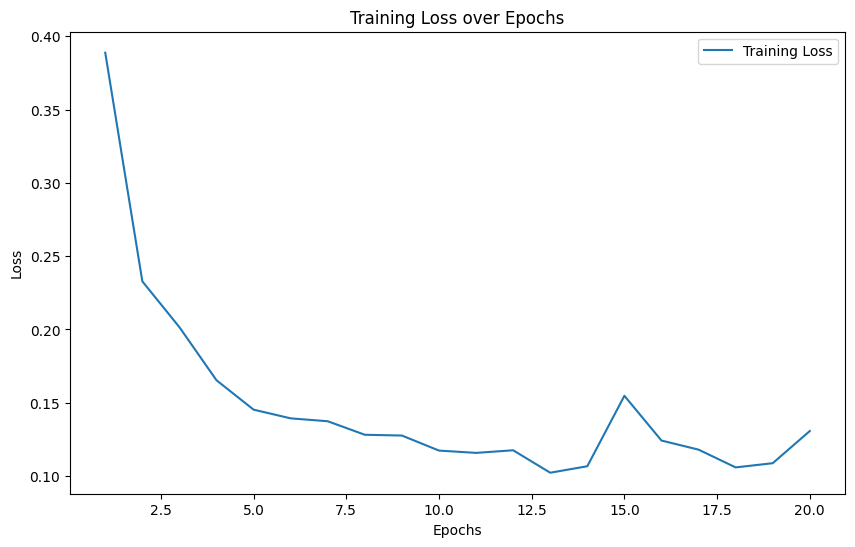

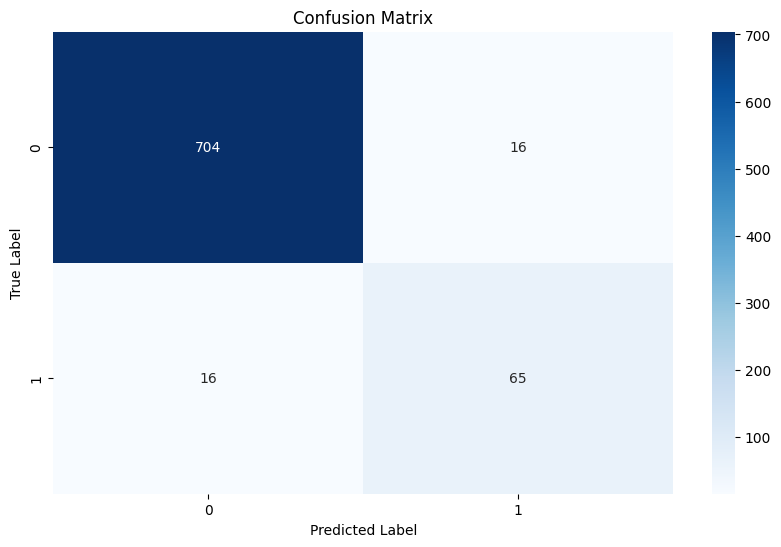

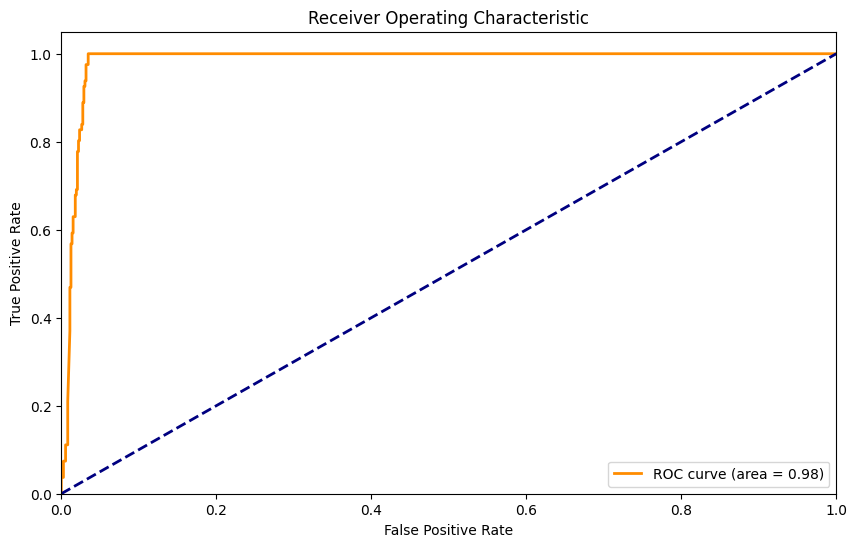

Confusion Matrix:
 [[704  16]
 [ 16  65]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       720
           1       0.80      0.80      0.80        81

    accuracy                           0.96       801
   macro avg       0.89      0.89      0.89       801
weighted avg       0.96      0.96      0.96       801



In [17]:
pyg_data_list = preprocess_data(data,window_size=100)
train_size = int(0.7 * len(pyg_data_list))
train_data = pyg_data_list[:train_size]
test_data = pyg_data_list[train_size:]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

model = EGraphSAGE(in_channels=1, hidden_channels=128, out_channels=2)  # in_channels=1 for PageRank only
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Training
train_model(model, train_loader, optimizer, criterion)

# Evaluation
cm, report = evaluate_model(model, test_loader)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', report)

# Save the model
save_model(model, os.path.join(output_dir, 'e_graphsage_model.pth'))



In [21]:
from torch_geometric.nn import GATConv

class EGraphGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphGAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)


In [22]:
def preprocess_data(data, window_size=100):
    pyg_data_list = []
    for window_start in tqdm(range(0, len(data), window_size)):
        window_end = min(window_start + window_size, len(data))
        window_data = data.iloc[window_start:window_end]
        G, index_tracker = create_graph(window_data)
        
        # Convert networkx graph to PyG data object
        pyg_data = from_networkx(G, group_node_attrs=['pagerank'])
        pyg_data.x = pyg_data.x.float()  # Ensure x is Float
        
        # Assign labels as specified
        labels = []
        for node in G.nodes:
            # Use the most recent label for each node
            labels.append(index_tracker[node][-1][1])
        pyg_data.y = torch.tensor(labels, dtype=torch.long)
        
        # Save the raw graph for later analysis
        graph_path = os.path.join(output_dir, f'graph_window_{window_start // window_size}.graphml')
        nx.write_graphml(G, graph_path)
        
        # Save the visualization of the graph
        visualize_graph(G, window_start // window_size)
        
        pyg_data_list.append(pyg_data)
    
    return pyg_data_list


In [23]:
def visualize_graph(G, window_index):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    
    # Ensure all nodes have a pagerank value, set default if missing
    for node in G.nodes():
        if node not in pagerank:
            pagerank[node] = 0.0  # Default PageRank value
    
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color='skyblue', font_size=10, edge_color='gray')
    plt.title(f"Graph for Window {window_index}")
    output_path = os.path.join(visualization_dir, f'graph_window_{window_index}.png')
    plt.savefig(output_path)
    plt.close()


In [24]:
def train_model(model, train_loader, optimizer, criterion, epochs=20):
    model.train()
    loss_values = []
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
        y_prob.extend(prob.tolist())
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Plot ROC curve
    plot_roc_curve(y_true, y_prob)
    
    return cm, report


100%|██████████| 2079/2079 [02:50<00:00, 12.20it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.5995030331870784
Epoch 2, Loss: 0.3735534237778705
Epoch 3, Loss: 0.31745712815419486
Epoch 4, Loss: 0.3087505860173184
Epoch 5, Loss: 0.3026751046595366
Epoch 6, Loss: 0.30471862658210425
Epoch 7, Loss: 0.29202572450689646
Epoch 8, Loss: 0.2954570336834244
Epoch 9, Loss: 0.2910768639134324
Epoch 10, Loss: 0.2901104437592237
Epoch 11, Loss: 0.28682171958296193
Epoch 12, Loss: 0.28468508273363113
Epoch 13, Loss: 0.28837850333555887
Epoch 14, Loss: 0.2893096869406493
Epoch 15, Loss: 0.2831233425632767
Epoch 16, Loss: 0.2846881374716759
Epoch 17, Loss: 0.28227786395860754
Epoch 18, Loss: 0.29136615311322006
Epoch 19, Loss: 0.2919454208534697
Epoch 20, Loss: 0.280066493736661


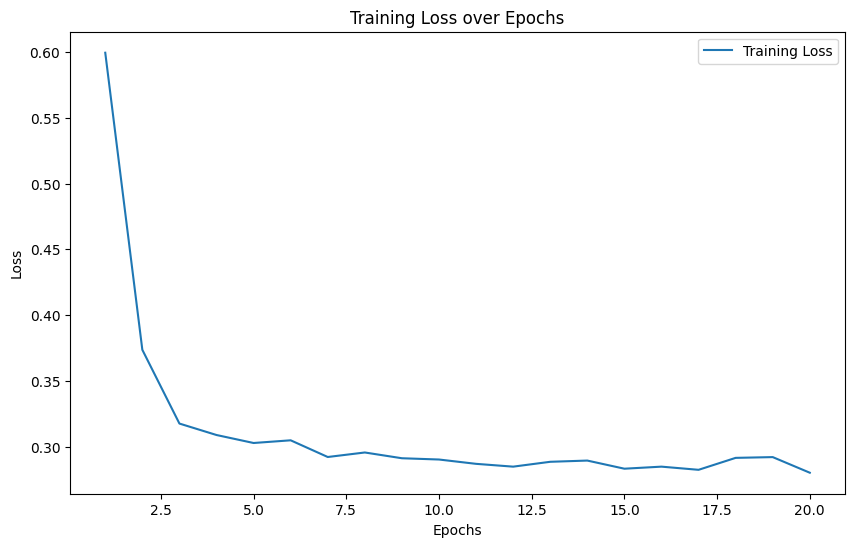

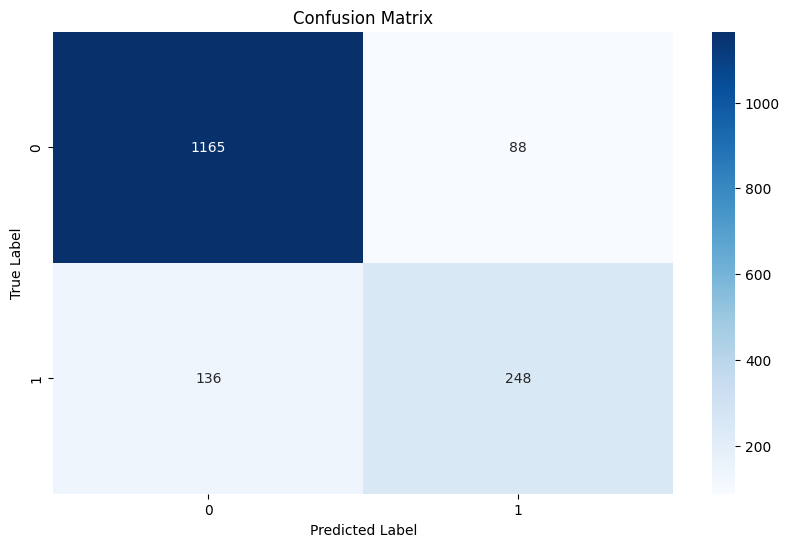

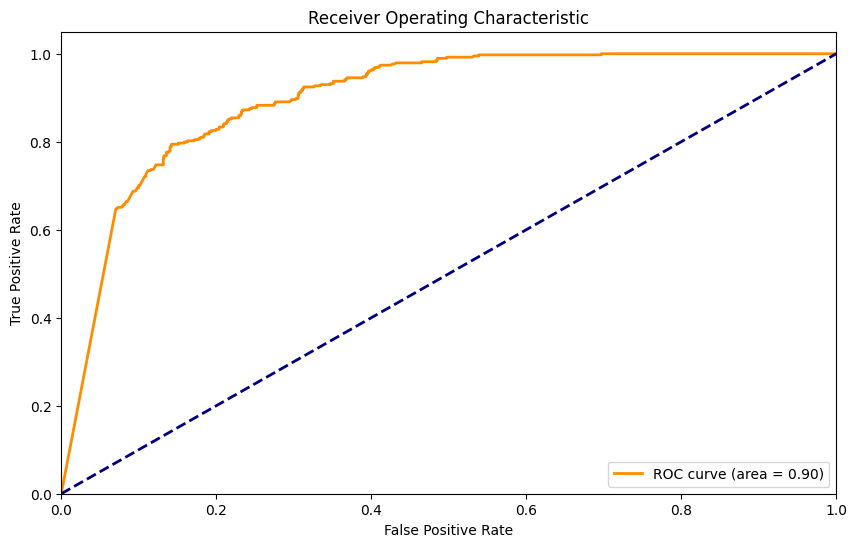

Confusion Matrix:
 [[1165   88]
 [ 136  248]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      1253
           1       0.74      0.65      0.69       384

    accuracy                           0.86      1637
   macro avg       0.82      0.79      0.80      1637
weighted avg       0.86      0.86      0.86      1637



In [25]:
# Main process
pyg_data_list = preprocess_data(data)
train_size = int(0.7 * len(pyg_data_list))
train_data = pyg_data_list[:train_size]
test_data = pyg_data_list[train_size:]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

model = EGraphGAT(in_channels=1, hidden_channels=128, out_channels=2)  # in_channels=1 for PageRank only
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Training
train_model(model, train_loader, optimizer, criterion)

# Evaluation
cm, report = evaluate_model(model, test_loader)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', report)

# Save the model
save_model(model, os.path.join(output_dir, 'e_graphgat_model.pth'))


Epoch 1, Loss: 0.33095416037932684
Epoch 2, Loss: 0.2380469924081927
Epoch 3, Loss: 0.23361059294446654
Epoch 4, Loss: 0.22785310414822205
Epoch 5, Loss: 0.21676399137662805
Epoch 6, Loss: 0.2096892036497593
Epoch 7, Loss: 0.20588862523436546
Epoch 8, Loss: 0.21466792844559834
Epoch 9, Loss: 0.20824989563097124
Epoch 10, Loss: 0.20279291320754134
Epoch 11, Loss: 0.1990489358811275
Epoch 12, Loss: 0.19831003005737843
Epoch 13, Loss: 0.2014239179375379
Epoch 14, Loss: 0.2055001924543277
Epoch 15, Loss: 0.1969009164882743
Epoch 16, Loss: 0.1987491562638594
Epoch 17, Loss: 0.19633187013475792
Epoch 18, Loss: 0.19839558863769408
Epoch 19, Loss: 0.19663791763393776
Epoch 20, Loss: 0.20329527394927066


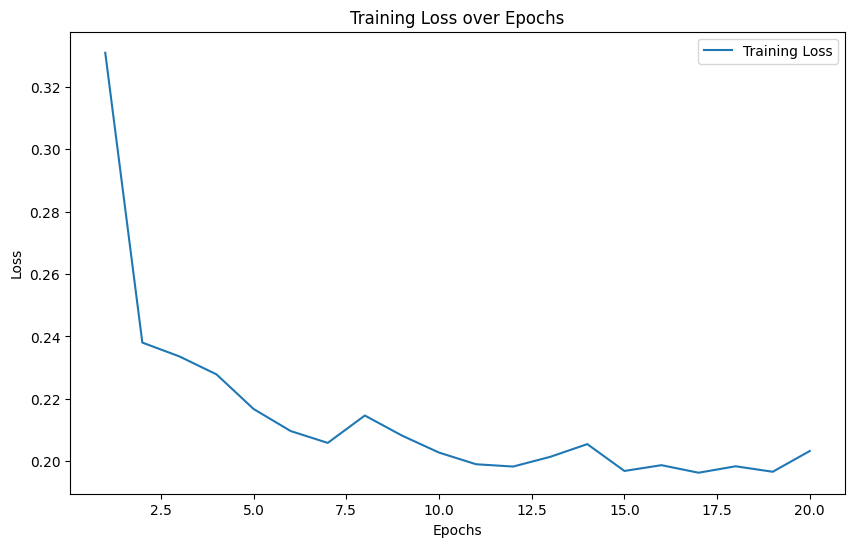

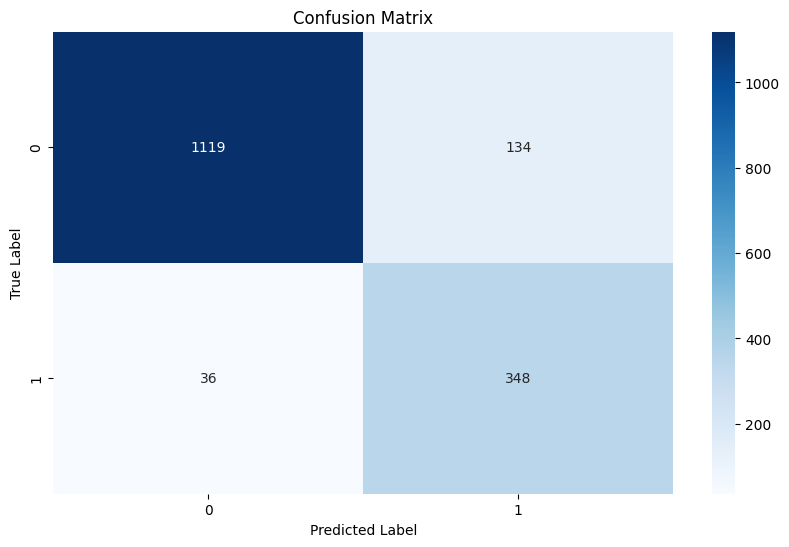

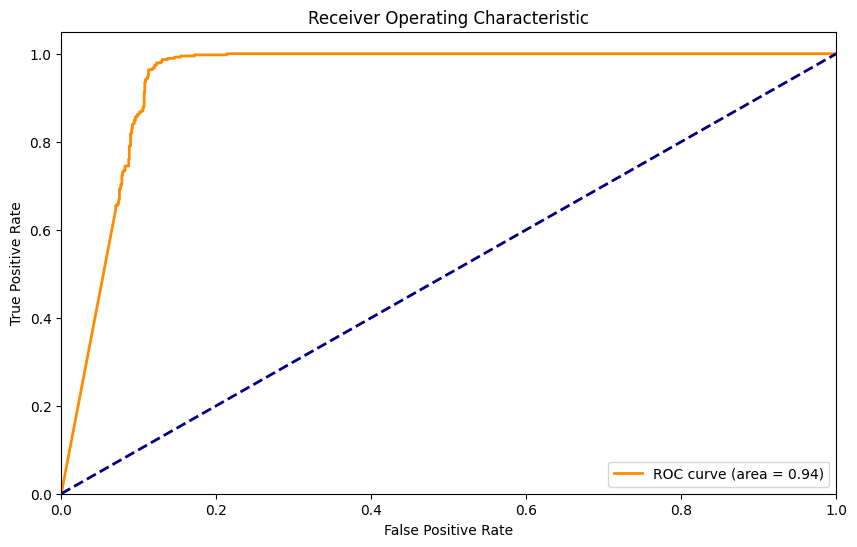

Confusion Matrix:
 [[1119  134]
 [  36  348]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      1253
           1       0.72      0.91      0.80       384

    accuracy                           0.90      1637
   macro avg       0.85      0.90      0.87      1637
weighted avg       0.91      0.90      0.90      1637



In [26]:
from torch_geometric.nn import TransformerConv

class EGraphTransformer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphTransformer, self).__init__()
        self.conv1 = TransformerConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)



model = EGraphTransformer(in_channels=1, hidden_channels=128, out_channels=2)  # in_channels=1 for PageRank only
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Training
train_model(model, train_loader, optimizer, criterion)

# Evaluation
cm, report = evaluate_model(model, test_loader)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', report)

# Save the model
save_model(model, os.path.join(output_dir, 'e_graphtransformer_model.pth'))

In [27]:
def create_graph(window_df, past_data):
    G = nx.DiGraph()
    index_tracker = {}
    
    for i in range(len(window_df) - 1):
        node1 = window_df.iloc[i]['can_id']
        node2 = window_df.iloc[i + 1]['can_id']
        timestamp_diff = window_df.iloc[i + 1]['timestamp'] - window_df.iloc[i]['timestamp']
        label = window_df.iloc[i]['label']
        transfer_id1 = window_df.iloc[i]['transfer_ID']
        transfer_id2 = window_df.iloc[i + 1]['transfer_ID']
        
        if node1 != node2 or transfer_id1 != transfer_id2:  # Allow self-loops only if transfer_IDs are different
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += timestamp_diff
            else:
                G.add_edge(node1, node2, weight=timestamp_diff)
        
        if node1 not in index_tracker:
            index_tracker[node1] = set()
        index_tracker[node1].add((i, label))
        
        if node2 not in index_tracker:
            index_tracker[node2] = set()
        index_tracker[node2].add((i, label))
    
    # Convert sets to sorted lists to ensure consistent ordering
    index_tracker = {k: sorted(list(v)) for k, v in index_tracker.items()}
    
    # Calculate optimized PageRank
    G = calculate_optimized_pagerank(G)
    
    # Calculate density for each node based on past data
    density = calculate_density(window_df, past_data)
    
    for node in G.nodes:
        G.nodes[node]['density'] = density.get(node, 0.0)
    
    return G, index_tracker

def calculate_density(window_df, past_data):
    density = {}
    combined_data = pd.concat([past_data, window_df])
    for node in window_df['can_id'].unique():
        node_count = combined_data[combined_data['can_id'] == node].shape[0]
        density[node] = node_count / combined_data.shape[0]
    return density


In [28]:
def preprocess_data(data, window_size=100, past_window_size=300):
    pyg_data_list = []
    past_data = pd.DataFrame()  # Initialize past data
    
    for window_start in tqdm(range(0, len(data), window_size)):
        window_end = min(window_start + window_size, len(data))
        window_data = data.iloc[window_start:window_end]
        
        # Create the graph with the current window and past data
        G, index_tracker = create_graph(window_data, past_data)
        
        # Convert networkx graph to PyG data object
        pyg_data = from_networkx(G, group_node_attrs=['pagerank', 'density'])
        pyg_data.x = pyg_data.x.float()  # Ensure x is Float
        
        # Assign labels as specified
        labels = []
        for node in G.nodes:
            # Use the most recent label for each node
            labels.append(index_tracker[node][-1][1])
        pyg_data.y = torch.tensor(labels, dtype=torch.long)
        
        # Save the raw graph for later analysis
        graph_path = os.path.join(output_dir, f'graph_window_{window_start // window_size}.graphml')
        nx.write_graphml(G, graph_path)
        
        # Save the visualization of the graph
        visualize_graph(G, window_start // window_size)
        
        pyg_data_list.append(pyg_data)
        
        # Update past data for the next iteration
        past_data = pd.concat([past_data, window_data]).iloc[-past_window_size:]
    
    return pyg_data_list


In [30]:
def evaluate_model(model, test_loader, title):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
        y_prob.extend(prob.tolist())
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()
    
    # Plot ROC curve
    plot_roc_curve(y_true, y_prob, title)
    
    return cm, report


100%|██████████| 2079/2079 [02:58<00:00, 11.64it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training GAT Model...
Epoch 1, Loss: 0.5637006299651187
Epoch 2, Loss: 0.3359707133925479
Epoch 3, Loss: 0.3019392849958461
Epoch 4, Loss: 0.2915158952059953
Epoch 5, Loss: 0.28859119020078494
Epoch 6, Loss: 0.27681626282308414
Epoch 7, Loss: 0.2717375204614971
Epoch 8, Loss: 0.2697773154663003
Epoch 9, Loss: 0.2719296816250552
Epoch 10, Loss: 0.2634280824466892
Epoch 11, Loss: 0.2610773457133252
Epoch 12, Loss: 0.26452827356431796
Epoch 13, Loss: 0.25931975148294284
Epoch 14, Loss: 0.2588025878952897
Epoch 15, Loss: 0.262280387075051
Epoch 16, Loss: 0.25934962733932165
Epoch 17, Loss: 0.2591101316654164
Epoch 18, Loss: 0.25599335457967676
Epoch 19, Loss: 0.25824895225789235
Epoch 20, Loss: 0.2628838722796544


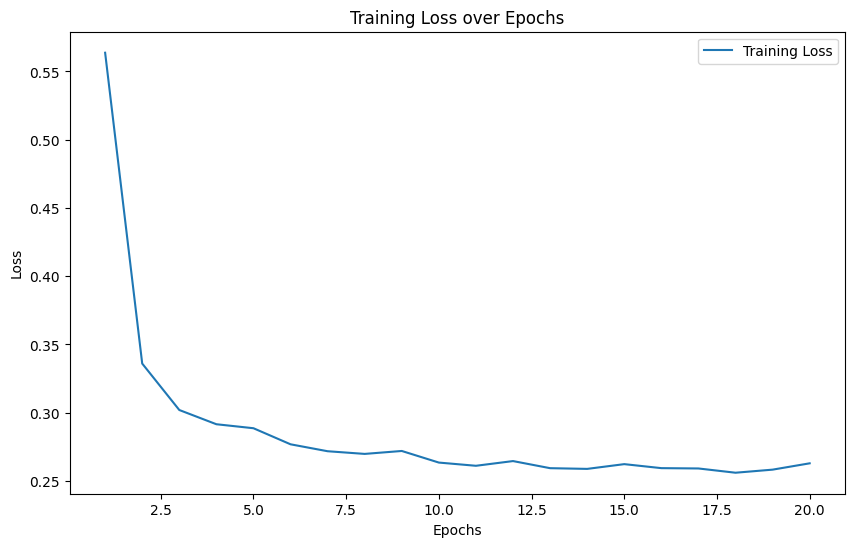

Evaluating GAT Model...


TypeError: evaluate_model() takes 2 positional arguments but 3 were given

In [29]:
# Main process
pyg_data_list = preprocess_data(data)
train_size = int(0.7 * len(pyg_data_list))
train_data = pyg_data_list[:train_size]
test_data = pyg_data_list[train_size:]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [32]:
def plot_roc_curve(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc='lower right')
    plt.show()


Training GAT Model...
Epoch 1, Loss: 0.571446066317351
Epoch 2, Loss: 0.3327526709307795
Epoch 3, Loss: 0.28775623181591864
Epoch 4, Loss: 0.2904608550926913
Epoch 5, Loss: 0.2769193552110506
Epoch 6, Loss: 0.2782971026456874
Epoch 7, Loss: 0.269174559932688
Epoch 8, Loss: 0.2651385331283445
Epoch 9, Loss: 0.2635290318209192
Epoch 10, Loss: 0.2661116090805634
Epoch 11, Loss: 0.2597220760324727
Epoch 12, Loss: 0.25884490006643796
Epoch 13, Loss: 0.2602526675099912
Epoch 14, Loss: 0.2591758551804916
Epoch 15, Loss: 0.2546785762128623
Epoch 16, Loss: 0.2560146175648855
Epoch 17, Loss: 0.25325010069038556
Epoch 18, Loss: 0.25610177154126373
Epoch 19, Loss: 0.25064246437471843
Epoch 20, Loss: 0.25649963141135546


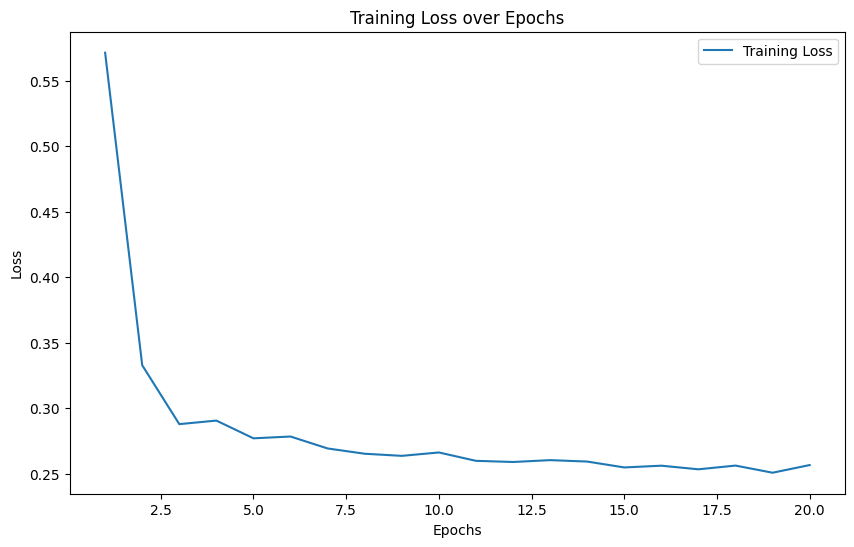

Evaluating GAT Model...


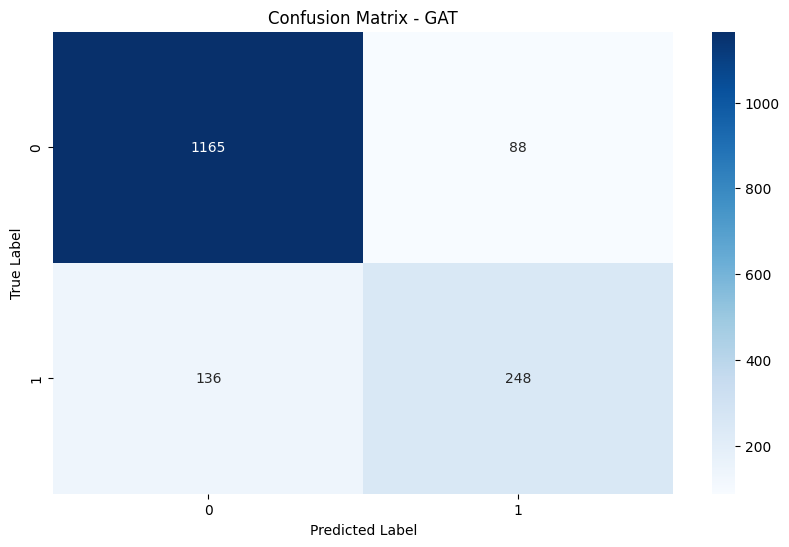

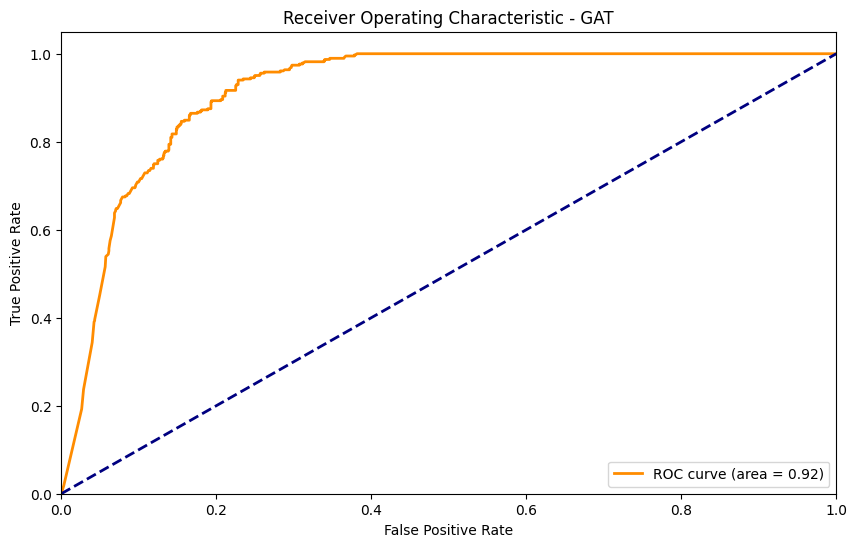

Confusion Matrix (GAT):
 [[1165   88]
 [ 136  248]]
Classification Report (GAT):
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      1253
           1       0.74      0.65      0.69       384

    accuracy                           0.86      1637
   macro avg       0.82      0.79      0.80      1637
weighted avg       0.86      0.86      0.86      1637

Training Transformer Model...
Epoch 1, Loss: 0.31051111302298046
Epoch 2, Loss: 0.22486868435921875
Epoch 3, Loss: 0.21324467658996582
Epoch 4, Loss: 0.19802597408061443
Epoch 5, Loss: 0.19594277344320132
Epoch 6, Loss: 0.19549163511913756
Epoch 7, Loss: 0.18832837514903233
Epoch 8, Loss: 0.18630405029524927
Epoch 9, Loss: 0.1816668895923573
Epoch 10, Loss: 0.1809573351689007
Epoch 11, Loss: 0.18154166250125223
Epoch 12, Loss: 0.17595799429261166
Epoch 13, Loss: 0.1755831479702307
Epoch 14, Loss: 0.17595631159518077
Epoch 15, Loss: 0.17718213229723598
Epoch 16, Loss: 0.179974494420963

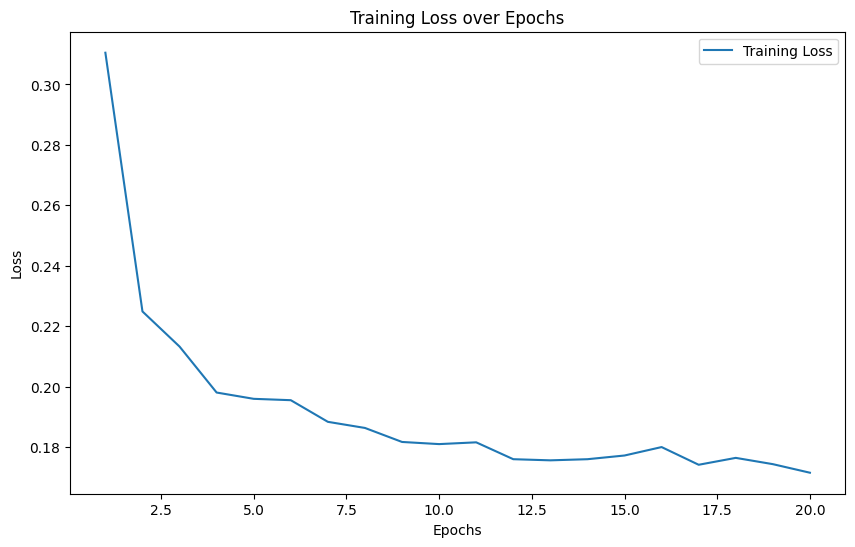

Evaluating Transformer Model...


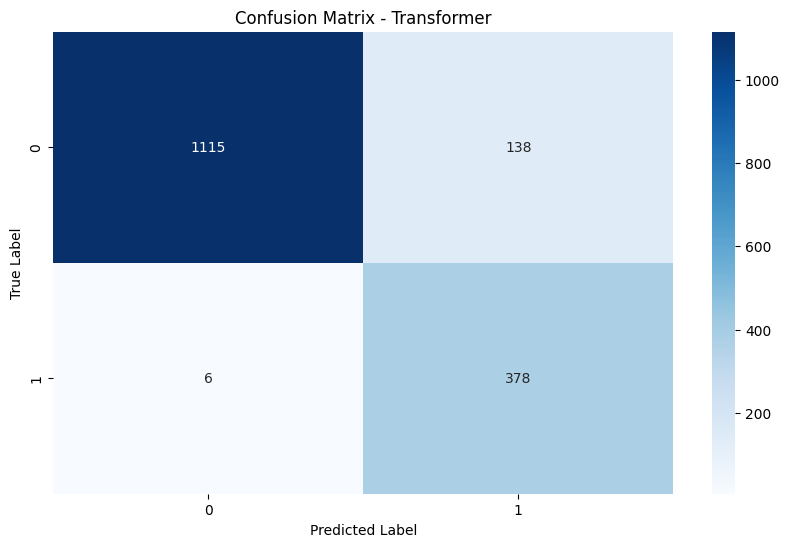

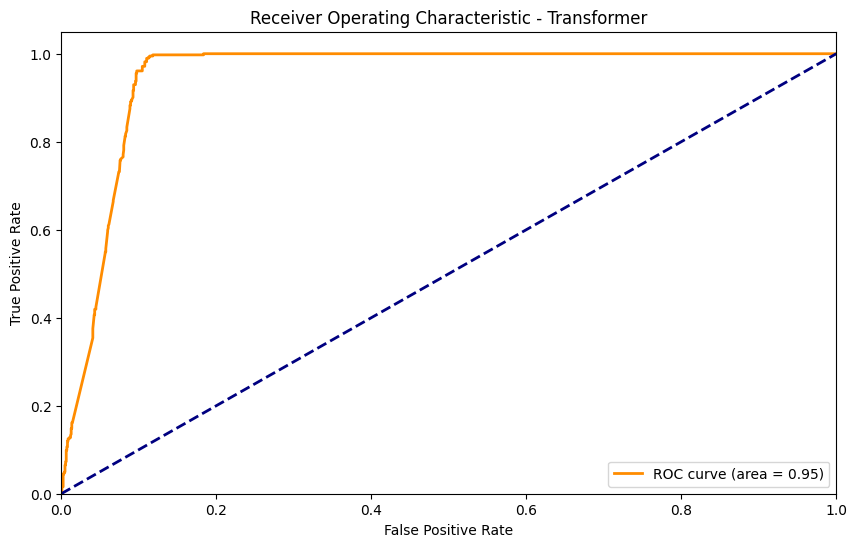

Confusion Matrix (Transformer):
 [[1115  138]
 [   6  378]]
Classification Report (Transformer):
               precision    recall  f1-score   support

           0       0.99      0.89      0.94      1253
           1       0.73      0.98      0.84       384

    accuracy                           0.91      1637
   macro avg       0.86      0.94      0.89      1637
weighted avg       0.93      0.91      0.92      1637



In [33]:

# GAT Model
model_gat = EGraphGAT(in_channels=2, hidden_channels=128, out_channels=2)  # in_channels=2 for PageRank and Density
optimizer_gat = torch.optim.Adam(model_gat.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Training GAT Model
print("Training GAT Model...")
train_model(model_gat, train_loader, optimizer_gat, criterion)

# Evaluation GAT Model
print("Evaluating GAT Model...")
cm_gat, report_gat = evaluate_model(model_gat, test_loader, "GAT")
print('Confusion Matrix (GAT):\n', cm_gat)
print('Classification Report (GAT):\n', report_gat)

# Save the GAT model
save_model(model_gat, os.path.join(output_dir, 'e_graphgat_model.pth'))

# Transformer Model
model_transformer = EGraphTransformer(in_channels=2, hidden_channels=128, out_channels=2)  # in_channels=2 for PageRank and Density
optimizer_transformer = torch.optim.Adam(model_transformer.parameters(), lr=0.001)

# Training Transformer Model
print("Training Transformer Model...")
train_model(model_transformer, train_loader, optimizer_transformer, criterion)

# Evaluation Transformer Model
print("Evaluating Transformer Model...")
cm_transformer, report_transformer = evaluate_model(model_transformer, test_loader, "Transformer")
print('Confusion Matrix (Transformer):\n', cm_transformer)
print('Classification Report (Transformer):\n', report_transformer)

# Save the Transformer model
save_model(model_transformer, os.path.join(output_dir, 'e_graphtransformer_model.pth'))


In [34]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import VGAE

class VariationalGraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(VariationalGraphEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


In [39]:
def train_vgae(model, train_loader, optimizer, epochs=20):
    model.train()
    loss_values = []
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            z = model.encode(data.x, data.edge_index)
            loss = model.recon_loss(z, data.edge_index)
            loss = loss + (1 / data.num_nodes) * model.kl_loss()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()
def evaluate_vgae(model, test_loader, threshold):
    model.eval()
    y_true = []
    y_pred = []
    for data in test_loader:
        z = model.encode(data.x, data.edge_index)
        
        # Calculate the reconstruction loss for each edge
        recon_loss_per_edge = model.recon_loss(z, data.edge_index).detach().numpy()
        
        # Aggregate loss per node (sum of losses of all edges connected to the node)
        node_loss = {}
        for i, (src, dst) in enumerate(data.edge_index.t().tolist()):
            if src not in node_loss:
                node_loss[src] = 0
            if dst not in node_loss:
                node_loss[dst] = 0
            node_loss[src] += recon_loss_per_edge[i]
            node_loss[dst] += recon_loss_per_edge[i]
        
        recon_loss_per_node = np.array([node_loss[node] for node in range(data.num_nodes)])
        
        y_true.extend(data.y.tolist())
        y_pred.extend((recon_loss_per_node > threshold).astype(int).tolist())
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    return cm, report


In [ ]:
def evaluate_vgae(model, test_loader, threshold):
    model.eval()
    y_true = []
    y_pred = []
    for data in test_loader:
        z = model.encode(data.x, data.edge_index)
        
        # Manually compute the reconstruction loss for each edge
        recon_loss_per_edge = []
        for src, dst in data.edge_index.t().tolist():
            recon_loss_per_edge.append(F.mse_loss(z[src], z[dst], reduction='none').sum().item())
        
        # Aggregate loss per node (sum of losses of all edges connected to the node)
        node_loss = {}
        for i, (src, dst) in enumerate(data.edge_index.t().tolist()):
            if src not in node_loss:
                node_loss[src] = 0
            if dst not in node_loss:
                node_loss[dst] = 0
            node_loss[src] += recon_loss_per_edge[i]
            node_loss[dst] += recon_loss_per_edge[i]
        
        recon_loss_per_node = np.array([node_loss.get(node, 0) for node in range(data.num_nodes)])
        
        y_true.extend(data.y.tolist())
        y_pred.extend((recon_loss_per_node > threshold).astype(int).tolist())
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    return cm, report


  0%|          | 0/2079 [00:00<?, ?it/s]

100%|██████████| 2079/2079 [02:55<00:00, 11.87it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training VGAE Model...
Epoch 1, Loss: 5.143466306769329
Epoch 2, Loss: 2.9966976590778516
Epoch 3, Loss: 2.131808576376542
Epoch 4, Loss: 2.005298941031746
Epoch 5, Loss: 1.9694169837495554
Epoch 6, Loss: 1.9291411353194194
Epoch 7, Loss: 1.8728150025657986
Epoch 8, Loss: 1.8606438921845478
Epoch 9, Loss: 1.840916060883066
Epoch 10, Loss: 1.847202894480332
Epoch 11, Loss: 1.8330246754314587
Epoch 12, Loss: 1.807157013727271
Epoch 13, Loss: 1.8075487224952034
Epoch 14, Loss: 1.8075212473454683
Epoch 15, Loss: 1.815802154333695
Epoch 16, Loss: 1.8013532135797583
Epoch 17, Loss: 1.8166189167810523
Epoch 18, Loss: 1.8105201176975085
Epoch 19, Loss: 1.8262485473052315
Epoch 20, Loss: 1.784240344296331


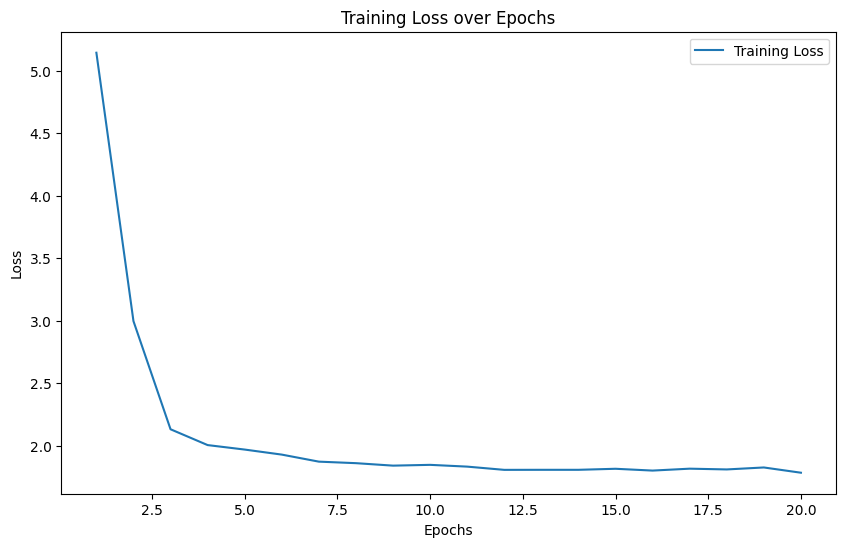

Evaluating VGAE Model...


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [41]:
# Main process
pyg_data_list = preprocess_data(data)
train_size = int(0.7 * len(pyg_data_list))
train_data = pyg_data_list[:train_size]
test_data = pyg_data_list[train_size:]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# VGAE Model
encoder = VariationalGraphEncoder(in_channels=2, hidden_channels=128, out_channels=64)  # in_channels=2 for PageRank and Density
model_vgae = VGAE(encoder)
optimizer_vgae = torch.optim.Adam(model_vgae.parameters(), lr=0.001)

# Training VGAE Model
print("Training VGAE Model...")
train_vgae(model_vgae, train_loader, optimizer_vgae)

# Determine a threshold for reconstruction loss
threshold = 0.01  # This should be tuned based on validation set or domain knowledge

# Evaluation VGAE Model
print("Evaluating VGAE Model...")
cm_vgae, report_vgae = evaluate_vgae(model_vgae, test_loader, threshold)
print('Confusion Matrix (VGAE):\n', cm_vgae)
print('Classification Report (VGAE):\n', report_vgae)

# Save the VGAE model
save_model(model_vgae, os.path.join(output_dir, 'vgae_model.pth'))


In [9]:

train_size = int(0.7 * len(pyg_data_list))
train_data = pyg_data_list[:train_size]
test_data = pyg_data_list[train_size:]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

model = EGraphSAGE(in_channels=1, hidden_channels=128, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_model(model, train_loader, optimizer, criterion)

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.30542018102562946
Epoch 2, Loss: 0.22798409086206686
Epoch 3, Loss: 0.21622074346827425
Epoch 4, Loss: 0.21625360976094785
Epoch 5, Loss: 0.20786878175061682
Epoch 6, Loss: 0.2066095623633136
Epoch 7, Loss: 0.20707024196567742
Epoch 8, Loss: 0.20491800198088522
Epoch 9, Loss: 0.2070652042394099
Epoch 10, Loss: 0.20076128953824873
Epoch 11, Loss: 0.20205643303368404
Epoch 12, Loss: 0.20151283721561017
Epoch 13, Loss: 0.2049584238101607
Epoch 14, Loss: 0.20028508211607518
Epoch 15, Loss: 0.20937965016650117
Epoch 16, Loss: 0.20147644161530162
Epoch 17, Loss: 0.1942639950176944
Epoch 18, Loss: 0.20320363990638568
Epoch 19, Loss: 0.1999636308654495
Epoch 20, Loss: 0.19722681233416434


In [10]:
cm, report = evaluate_model(model, test_loader)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', report)

Confusion Matrix:
 [[1115  138]
 [  33  351]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      1253
           1       0.72      0.91      0.80       384

    accuracy                           0.90      1637
   macro avg       0.84      0.90      0.87      1637
weighted avg       0.91      0.90      0.90      1637



In [12]:
save_model(model, os.path.join(output_dir, 'graphsage_model_lstm.pth'))

In [21]:
from torch_geometric.nn import GCNConv
class GCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

In [22]:

model2 = GCNN(in_channels=1, hidden_channels=128, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [23]:

train_model(model2, train_loader, optimizer, criterion)

Epoch 1, Loss: 0.6961166158966396
Epoch 2, Loss: 0.6960158309210902
Epoch 3, Loss: 0.6961866293264471
Epoch 4, Loss: 0.6962129875369694
Epoch 5, Loss: 0.696018108855123
Epoch 6, Loss: 0.6955929074598395
Epoch 7, Loss: 0.6959004596523617
Epoch 8, Loss: 0.696125618789507
Epoch 9, Loss: 0.6957598808019058
Epoch 10, Loss: 0.6961407700310582
Epoch 11, Loss: 0.6963170753872913
Epoch 12, Loss: 0.6954345651294874
Epoch 13, Loss: 0.6959811578626218
Epoch 14, Loss: 0.6966515520344609
Epoch 15, Loss: 0.6963633739429972
Epoch 16, Loss: 0.6953185187733691
Epoch 17, Loss: 0.6959081616090692
Epoch 18, Loss: 0.6956511969151704
Epoch 19, Loss: 0.6956994533538818
Epoch 20, Loss: 0.6959719696770543


In [24]:
cm, report = evaluate_model(model, test_loader)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', report)

Confusion Matrix:
 [[1117  136]
 [  40  344]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      1253
           1       0.72      0.90      0.80       384

    accuracy                           0.89      1637
   macro avg       0.84      0.89      0.86      1637
weighted avg       0.91      0.89      0.90      1637



In [1]:
report

NameError: name 'report' is not defined

: 